In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
import geopandas as gpd
from shapely.wkt import loads
from pyproj import Proj, Transformer

In [2]:

def lat_lon_to_axis(lat, lon, axis_direction=(1, 0), crs="EPSG:3857"):
    """
    Convert latitude and longitude to a one-dimensional value in meters along an axis.

    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        axis_direction (tuple): Direction vector of the axis (x, y).
        crs (str): CRS for projecting to meters (default: EPSG:3857).

    Returns:
        float: One-dimensional projection value in meters.
    """
    
    # Define the transformer for projecting lat/lon to the desired CRS
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    
    # Project the latitude and longitude to meters
    x, y = transformer.transform(lon, lat)
    
    # Normalize the axis direction vector
    axis_vector = np.array(axis_direction)
    axis_unit_vector = axis_vector / np.linalg.norm(axis_vector)
    
    # Compute the projection of the point onto the axis
    projection_value = np.dot([x, y], axis_unit_vector)
    return projection_value

def find_traffic_light_id(row, segments_gdf):
    """
    Find the nearest segment ID to a given row in a DataFrame.

    Args:
        row (pd.Series): Row in a DataFrame with columns 'lat' and 'lon'.
        segments_gdf (gpd.GeoDataFrame): GeoDataFrame with segment geometries.

    Returns:
        int: ID of the nearest segment.
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        geometry=[loads(f"POINT ({row['lat']} {row['lon']})")], crs="EPSG:4326" # Make sure lat and lon is given completely right! Lat first then lon
    )
    
    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:4326"  # Common projected CRS for distance calculations
    point_proj = point.to_crs(projected_crs)
    segments_gdf_proj = segments_gdf.to_crs(projected_crs)
    max_distance = float("inf")
    nearest_segment_id = None
    for index, row in segments_gdf_proj.iterrows():
        distance = row.geometry.distance(point_proj.geometry[0])
        if distance < max_distance:
            max_distance = distance
            nearest_segment_id = index
    return nearest_segment_id


In [3]:
# loading the main dataframe
main_df = pd.read_csv("20181024_d1_0830_0900_traffic_segmented.csv")
# loading the traffic light states
with open("20181024_d1_0830_0900_traffic_light_states.json") as f:
    traffic_info = json.load(f)
# loading the segments
segments_gdf = gpd.read_file("20181024_d1_0830_0900_traffic_lights_segments.csv")
# Convert to GeoDataFrame
if "geometry" in segments_gdf.columns:
    # Convert 'geometry' to shapely objects if needed
    segments_gdf["geometry"] = segments_gdf["geometry"].apply(loads)
    # Create GeoDataFrame and set the CRS to WGS 84 (latitude/longitude)
    segments_gdf = gpd.GeoDataFrame(segments_gdf, geometry="geometry", crs="EPSG:4326")
else:
    raise ValueError("The DataFrame does not have a 'geometry' column.")

# Reproject to a projected CRS (replace EPSG code with appropriate UTM zone)
segments_gdf = segments_gdf.to_crs("EPSG:25832")  # Example for UTM Zone 32N

# Calculate lengths
segments_gdf["length"] = segments_gdf.geometry.length
segments_gdf = segments_gdf.to_crs("EPSG:4326")  # Example for UTM Zone 32N

lon_one_axis_trajectory = []
lat_one_axis_trajectory = []
for i, row in segments_gdf.iterrows():
    lat_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[0][1], row.geometry.coords.xy[0][0], crs="EPSG:4326"))
    lon_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[1][1], row.geometry.coords.xy[1][0], crs="EPSG:4326"))

segments_gdf["lon_one_axis_trajectory"] = lon_one_axis_trajectory
segments_gdf["lat_one_axis_trajectory"] = lat_one_axis_trajectory

# Calculate total length
total_length = segments_gdf["length"].sum()

# loading the traffic lights
traffic_lights_df = pd.read_csv("traffic_lights.csv")
# find traffic light segment id
traffic_lights_df["nearest_segment_id"] = traffic_lights_df.apply(find_traffic_light_id, axis=1, segments_gdf=segments_gdf)
traffic_lights_df = traffic_lights_df.iloc[:5, :]
# loading the traffic light states
with open("traffic_info_dict.pkl", "rb") as f:
    traffic_lights_dict_states = pickle.load(f)

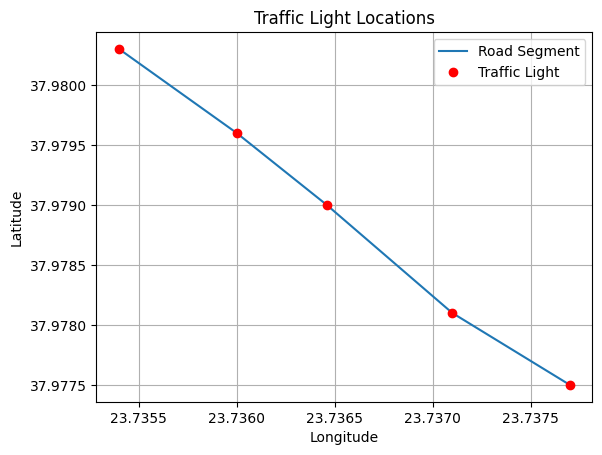

In [4]:
plt.plot(segments_gdf["lon_one_axis_trajectory"], segments_gdf["lat_one_axis_trajectory"], "-", label="Road Segment")
plt.plot(traffic_lights_df["lon"], traffic_lights_df["lat"], "ro", label="Traffic Light")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Traffic Light Locations")
plt.legend()
plt.ticklabel_format(useOffset=False)
plt.grid()
plt.show()

# Define the constants for truncating

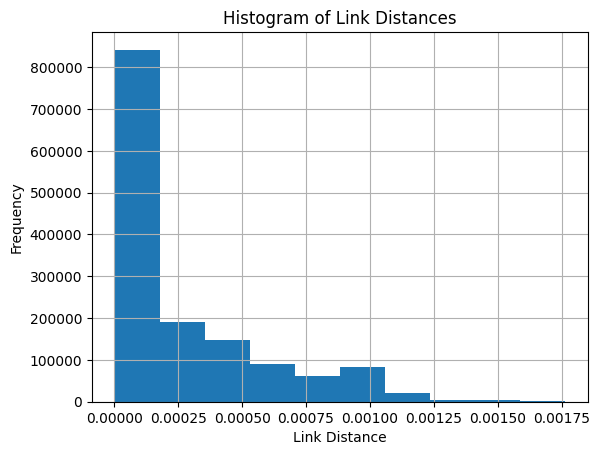

In [6]:
plt.hist(main_df["link_distance"])
plt.title("Histogram of Link Distances")
plt.xlabel("Link Distance")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [7]:
DISTANCE_THRESHOLD = 0.0001

# Normalize the one axis trajectory

In [8]:
from CTM_classic import CTMParameters, initialize_density, update_cell_status
from sklearn.preprocessing import normalize

# Initialize CTM parameters
ctm_params = CTMParameters()
ctm_params.segment_length = segments_gdf["length"].mean()
ctm_params.cell_length= 6

# Truncate points that are too far from the main corridor line
main_df_truncated = main_df[main_df["link_distance"] < DISTANCE_THRESHOLD].copy()  # Ensure it's a copy
# main_df_truncated["one_axis_trajectory"] = main_df_truncated.apply(lambda row: lat_lon_to_axis(row["lat"], row["lon"], crs="EPSG:4326"), axis=1)

# Normalize trajectory
normalized_trajectory = (
    main_df_truncated["one_axis_trajectory"] - main_df_truncated["one_axis_trajectory"].min()
)
normalized_trajectory = normalized_trajectory / normalized_trajectory.max() * segments_gdf["length"].sum()

# Assign to the DataFrame safely
main_df_truncated.loc[:, "normalized_trajectory"] = normalized_trajectory
main_df_truncated

,lat,lon,speed,lon_acc,lat_acc,time,veh_id,link_id,link_distance,one_axis_trajectory,normalized_trajectory
0,37.977391,23.737688,4.9178,0.0518,-0.0299,0.00,1,4,0.000012,2.642467e+06,549.980416
1,37.977391,23.737688,4.9207,-0.0124,-0.0354,0.04,1,4,0.000012,2.642467e+06,549.980416
2,37.977391,23.737688,4.9160,-0.0519,-0.0413,0.08,1,4,0.000012,2.642467e+06,549.980416
3,37.977390,23.737688,4.9057,-0.0914,-0.0478,0.12,1,4,0.000012,2.642467e+06,549.980416
4,37.977390,23.737689,4.8871,-0.1679,-0.0550,0.16,1,4,0.000011,2.642467e+06,550.210822
...,...,...,...,...,...,...,...,...,...,...,...
1446233,37.980044,23.735572,28.9885,0.3464,0.7262,818.64,918,0,0.000036,2.642232e+06,62.440173
1446234,37.980041,23.735574,29.0103,0.3757,0.7476,818.68,918,0,0.000036,2.642232e+06,62.900986
1446235,37.980039,23.735576,29.0349,0.3894,0.7668,818.72,918,0,0.000036,2.642232e+06,63.361799
1446236,37.980036,23.735577,29.0621,0.4186,0.7833,818.76,918,0,0.000037,2.642232e+06,63.592206


In [9]:
from shapely.geometry import LineString
# Initialize densities for each segment
segment_densities_predicted = {idx: initialize_density(ctm_params, segments_gdf.iloc[idx]["length"]) for idx in segments_gdf.index}

def divide_linestring(linestring, n):
    """
    Divides a LINESTRING into n equal parts.

    :param linestring: A Shapely LineString object
    :param n: Number of equal parts to divide into
    :return: A list of LineString objects representing the segments
    """
    if not isinstance(linestring, LineString):
        raise ValueError("Input must be a Shapely LineString")

    # Get the total length of the LineString
    total_length = linestring.length

    # Calculate the step for division
    distances = np.linspace(0, total_length, n + 1)

    # Create parts
    parts = []
    for i in range(len(distances) - 1):
        start_point = linestring.interpolate(distances[i])
        end_point = linestring.interpolate(distances[i + 1])
        parts.append(LineString([start_point, end_point]))

    return gpd.GeoSeries(parts)

cells_linestring = []
for segment_id, segment in segments_gdf.iterrows():
    # Divide the segment into cells
    cells = divide_linestring(segment["geometry"], len(segment_densities_predicted[segment_id])) #‌ TODO check if the length of the cells is correct
    cells_linestring.append(cells)

# Flatten the cells into a new column for each segment
segments_gdf["cells_linestring"] = cells_linestring

# If you want to ensure individual cells are separate rows, you can explode the column
segments_gdf_exploded = segments_gdf.explode("cells_linestring").reset_index().rename(columns={"index": "segment_id"})


# Group by `segment_id` and collect `cells_linestring` into lists
grouped = segments_gdf_exploded.groupby("segment_id")["cells_linestring"].apply(list).reset_index()

# Expand the lists into separate columns
expanded = pd.DataFrame(grouped["cells_linestring"].tolist(), index=grouped["segment_id"])

# Add the other columns you want to retain (e.g., `geometry`, `length`, etc.)
metadata = segments_gdf_exploded.drop_duplicates(subset="segment_id").set_index("segment_id")[["geometry", "length", "lon_one_axis_trajectory", "lat_one_axis_trajectory"]]
segments_gdf_exploded = metadata.join(expanded)

# Rename the columns for clarity (optional)
segments_gdf_exploded.columns = list(metadata.columns) + [f"cell_{i+1}" for i in range(expanded.shape[1])]

# Reset index for a clean DataFrame
segments_gdf_exploded = segments_gdf_exploded.reset_index()
for column in segments_gdf_exploded.columns:
    if column.startswith("cell_"):
        segments_gdf_exploded[column] = gpd.GeoSeries(segments_gdf_exploded[column])
segments_gdf_exploded.head(2)

,segment_id,geometry,length,lon_one_axis_trajectory,lat_one_axis_trajectory,cell_1,cell_2,cell_3,cell_4,cell_5,...,cell_15,cell_16,cell_17,cell_18,cell_19,cell_20,cell_21,cell_22,cell_23,cell_24
0,0,"LINESTRING (37.9803 23.7354, 37.9796 23.736)",108.829563,23.7354,37.9803,"LINESTRING (37.9803 23.7354, 37.98026 23.73543)","LINESTRING (37.98026 23.73543, 37.98022 23.73547)","LINESTRING (37.98022 23.73547, 37.98018 23.7355)","LINESTRING (37.98018 23.7355, 37.98014 23.73553)","LINESTRING (37.98014 23.73553, 37.98011 23.73557)",...,"LINESTRING (37.97976 23.73587, 37.97972 23.7359)","LINESTRING (37.97972 23.7359, 37.97968 23.73593)","LINESTRING (37.97968 23.73593, 37.97964 23.73597)","LINESTRING (37.97964 23.73597, 37.9796 23.736)",None,None,None,None,None,None
1,1,"LINESTRING (37.9796 23.736, 37.979 23.73646)",88.845240,23.7360,37.9796,"LINESTRING (37.9796 23.736, 37.97956 23.73603)","LINESTRING (37.97956 23.73603, 37.97951 23.73607)","LINESTRING (37.97951 23.73607, 37.97947 23.7361)","LINESTRING (37.97947 23.7361, 37.97943 23.73613)","LINESTRING (37.97943 23.73613, 37.97939 23.73616)",...,None,None,None,None,None,None,None,None,None,None


In [10]:
len(segment_densities_predicted[1])

14

# Find the closest cell (Skip if already run)

In [120]:
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm  # Import tqdm for progress

def find_closest_cell(lat, lon, link_id, segments_gdf_exploded):
    """
    Find the nearest segment ID to a given point.
    
    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        segments_gdf_exploded (GeoDataFrame): GeoDataFrame with segment geometries and cell data.
    
    Returns:
        str: ID of the nearest cell (e.g., 'cell_1').
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        geometry=[Point(lat, lon)], crs="EPSG:4326"
    )

    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:3395"  # Consider using a projected CRS suitable for distance measurements
    point_proj = point.to_crs(projected_crs)

    max_distance = float("inf")
    nearest_cell_id = None

    # Iterate through the segments and calculate distances
    for index, row in segments_gdf_exploded.iloc[[link_id]].iterrows():
        cell_columns = row.filter(regex=r'^cell_\d')  # Use raw string to avoid escape sequence warning
        if not cell_columns.empty:
            for cell_id, cell_value in cell_columns.items():
                if cell_value is None and int(cell_id.split("_")[1]) > len(segment_densities_predicted[index]):  # Skip empty cells
                    
                    continue
                # Assuming the cell_value corresponds to a geometry, e.g., a LineString or Polygon
                cell_geometry = segments_gdf_exploded.at[index, cell_id]
                # Convert to GeoSeries and reproject
                if isinstance(cell_geometry, gpd.GeoSeries):
                    cell_geometry = cell_geometry.to_crs(projected_crs)
                else:
                    cell_geometry = gpd.GeoSeries([cell_geometry], crs=segments_gdf_exploded.crs).to_crs(projected_crs).iloc[0]
                if cell_geometry and cell_geometry.is_valid:  # Ensure the geometry is valid
                    # Calculate the distance from the point to the cell geometry
                    distance = point_proj.distance(cell_geometry)

                    # Check if distance is scalar (just in case it's returned as a Series)
                    if isinstance(distance, (float, int)):  # Ensure it's a scalar
                        if distance < max_distance:
                            max_distance = distance
                            nearest_cell_id = cell_id  # Capture the ID of the nearest cell
                    else:
                        # Handle the case where distance is a Series or other unexpected result
                        distance = distance.item()  # Convert to scalar if it's a Series
                        if distance < max_distance:
                            max_distance = distance
                            nearest_cell_id = cell_id

    return nearest_cell_id

main_df_truncated_with_cell = main_df_truncated.copy()

main_df_truncated_with_cell["closest_cell"] = [
    find_closest_cell(row["lat"], row["lon"], int(row["link_id"]), segments_gdf_exploded) 
    for _, row in tqdm(main_df_truncated_with_cell.iterrows(), total=len(main_df_truncated_with_cell), desc="Processing Rows")
]

# print(f"The nearest cell IDs are: {main_df_truncated_with_cell['closest_cell']}")

main_df_truncated_with_cell.to_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell.csv")

Processing Rows: 100%|██████████| 698192/698192 [53:31<00:00, 217.42it/s]  


In [121]:
main_df_truncated_with_cell

,lat,lon,speed,lon_acc,lat_acc,time,veh_id,link_id,link_distance,one_axis_trajectory,normalized_trajectory,closest_cell
0,37.977391,23.737688,4.9178,0.0518,-0.0299,0.00,1,4,0.000012,2.642467e+06,549.980416,cell_3
1,37.977391,23.737688,4.9207,-0.0124,-0.0354,0.04,1,4,0.000012,2.642467e+06,549.980416,cell_3
2,37.977391,23.737688,4.9160,-0.0519,-0.0413,0.08,1,4,0.000012,2.642467e+06,549.980416,cell_3
3,37.977390,23.737688,4.9057,-0.0914,-0.0478,0.12,1,4,0.000012,2.642467e+06,549.980416,cell_3
4,37.977390,23.737689,4.8871,-0.1679,-0.0550,0.16,1,4,0.000011,2.642467e+06,550.210822,cell_3
...,...,...,...,...,...,...,...,...,...,...,...,...
1446233,37.980044,23.735572,28.9885,0.3464,0.7262,818.64,918,0,0.000036,2.642232e+06,62.440173,cell_6
1446234,37.980041,23.735574,29.0103,0.3757,0.7476,818.68,918,0,0.000036,2.642232e+06,62.900986,cell_6
1446235,37.980039,23.735576,29.0349,0.3894,0.7668,818.72,918,0,0.000036,2.642232e+06,63.361799,cell_7
1446236,37.980036,23.735577,29.0621,0.4186,0.7833,818.76,918,0,0.000037,2.642232e+06,63.592206,cell_7


In [11]:
import pandas as pd

# Read the CSV file
main_df_truncated_with_cell = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell.csv")

# Group by the desired columns and aggregate the vehicle IDs into a frozenset
grouped_with_veh_ids = main_df_truncated_with_cell.groupby(["link_id", "time", "closest_cell"]).agg({
    "veh_id": lambda x: frozenset(x)  # Use frozenset instead of set
}).reset_index()

# Merge the new column back into the original dataframe
main_df_truncated_with_cell = main_df_truncated_with_cell.merge(grouped_with_veh_ids, on=["link_id", "time", "closest_cell"], suffixes=('', '_list'))

# Rename the new column for clarity
main_df_truncated_with_cell.rename(columns={"veh_id_list": "veh_id_list"}, inplace=True)

# Display the shapes
duplicate_dropped = main_df_truncated_with_cell.drop_duplicates(subset=["link_id", "time", "closest_cell", "veh_id_list"])[["veh_id_list", "link_id", "time", "closest_cell"]]

# Get inflow of the first cell

In [12]:
# Filter the DataFrame for closest_cell == "cell_1"
cell_1 = duplicate_dropped[duplicate_dropped["closest_cell"] == "cell_1"]
_dict = {}
# Process each link_id group separately
for link_id in cell_1["link_id"].unique():
    # Filter the DataFrame for the current link_id
    link_df = cell_1[cell_1["link_id"] == link_id].copy()
    
    # Compute the deletion list as the set difference between the current and previous rows
    link_df["veh_id_list_deletion"] = link_df["veh_id_list"].diff().apply(
        lambda x: x if isinstance(x, frozenset) else frozenset()
    ).apply(
        lambda x: x if not pd.isna(x) else frozenset()
    )
    
    
    link_df["inflow"] = link_df["veh_id_list_deletion"].apply(len)
    _dict[link_id] = link_df[["inflow", "time"]]



# Save inflow

In [13]:
inflow = pd.DataFrame({})
for index, value in _dict.items():
    value["link_id"] = index
    inflow = pd.concat([inflow, value])
inflow.to_csv("20181024_d1_0830_0900_inflow.csv")

/var/folders/08/xlt8ht5x04x0hg_fhxdwdl7m0000gr/T/ipykernel_97203/3882679768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value["link_id"] = index


# Get free flow speed

## draw histogram plot

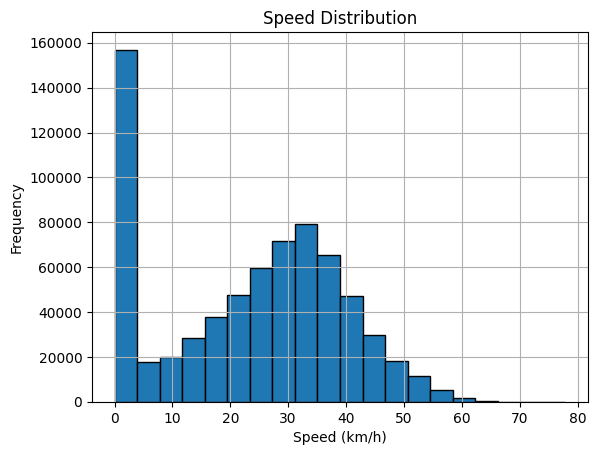

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
 
speeds = main_df_truncated_with_cell['speed']

plt.hist(speeds, bins=20, edgecolor='black')
plt.title("Speed Distribution")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

## Calculate the free flow speed

In [15]:
import numpy as np
free_flow_threshold = 25 
free_flow_speeds = speeds[speeds > free_flow_threshold]

mean_speed = np.mean(free_flow_speeds)
percentile_85 = np.percentile(free_flow_speeds, 85)

print(f"Free Flow Speed (Mean): {mean_speed} km/h")
print(f"Free Flow Speed (85th Percentile): {percentile_85} km/h")


Free Flow Speed (Mean): 36.15381621480552 km/h
Free Flow Speed (85th Percentile): 44.152950000000004 km/h


## Converting the free flow speed to m/s

In [16]:
percentile_85_m_s = percentile_85/3.6
ctm_params.free_flow_speed = percentile_85_m_s

# Grouping the data based on segment_id, cell_id and time

In [17]:
grouped = duplicate_dropped.groupby(["closest_cell", "link_id", "time"])
vehicle_count = grouped.size().reset_index(name="vehicle_count")
vehicle_count["density"] = vehicle_count["vehicle_count"] / ctm_params.cell_length
vehicle_count

,closest_cell,link_id,time,vehicle_count,density
0,cell_1,0,0.00,1,0.166667
1,cell_1,0,0.04,1,0.166667
2,cell_1,0,0.08,1,0.166667
3,cell_1,0,0.12,1,0.166667
4,cell_1,0,0.16,1,0.166667
...,...,...,...,...,...
527558,cell_9,4,791.24,1,0.166667
527559,cell_9,4,791.28,1,0.166667
527560,cell_9,4,791.32,1,0.166667
527561,cell_9,4,791.36,1,0.166667


# Testing the CTM model

In [18]:
def get_density_for_time(segment_id, time, vehicle_count):
    t0 = time
    density_t0 = vehicle_count[(vehicle_count["link_id"] == segment_id) & (vehicle_count["time"] == t0)]
    density_t0_initialized = segment_densities_predicted[segment_id].copy()
    for index, row in density_t0.iterrows():
        density_t0_initialized[int(row["closest_cell"].split("_")[-1])-1] = row["density"]


    t1 = t0 + ctm_params.time_step


    density_t1 = vehicle_count[(vehicle_count["link_id"] == segment_id) & (vehicle_count["time"] == t1)]
    density_t1_initialized = segment_densities_predicted[segment_id].copy()
    for index, row in density_t1.iterrows():
        density_t1_initialized[int(row["closest_cell"].split("_")[-1])-1] = row["density"]
    density_t1_initialized = np.array(density_t1_initialized)
    density_t0_initialized = np.array(density_t0_initialized)
    # print("density_density_t0_initialized", density_t0_initialized, "density_t1_initialized", density_t1_initialized)
    return density_t0_initialized, density_t1_initialized
actual_values_dict = {}
predicted_values_dict = {}
rmses_dict = {}
times_dict = {}
predict_mean_dict = {}
actual_mean_dict = {}


for segment_id in vehicle_count["link_id"].unique():
    rmses = []
    times = []
    predict_mean = []
    actual_mean = []
    predicted_values = []
    actual_values = []
    for unique_time in vehicle_count[vehicle_count["link_id"] == segment_id]["time"].unique(): 
        density_t0_initialized, density_t1_initialized = get_density_for_time(segment_id, unique_time, vehicle_count)
        inflow_dt = inflow[(inflow["time"] == unique_time) & (inflow["link_id"] == segment_id)]
        if inflow_dt.empty:
            inflow_dt = 0
        else:
            inflow_dt = inflow_dt["inflow"].values[0]
        predicted_den = np.array(update_cell_status(unique_time, segment_id, density_t0_initialized, ctm_params, 0, traffic_lights_df, traffic_lights_dict_states))
        predict_mean.append(predicted_den[:].mean())
        predicted_value = predicted_den[:]
        actual_value = density_t1_initialized[:]

        rmse = np.sqrt(np.mean((predicted_value - actual_value)**2))
        predicted_values.append(predicted_value)
        actual_values.append(actual_value)
        actual_mean.append(density_t0_initialized[:].mean())
        rmses.append(rmse)
        times.append(unique_time)
    actual_values_dict[segment_id] = actual_values
    predicted_values_dict[segment_id] = predicted_values
    rmses_dict[segment_id] = rmses
    times_dict[segment_id] = times
    predict_mean_dict[segment_id] = predict_mean
    actual_mean_dict[segment_id] = actual_mean


# Plotting

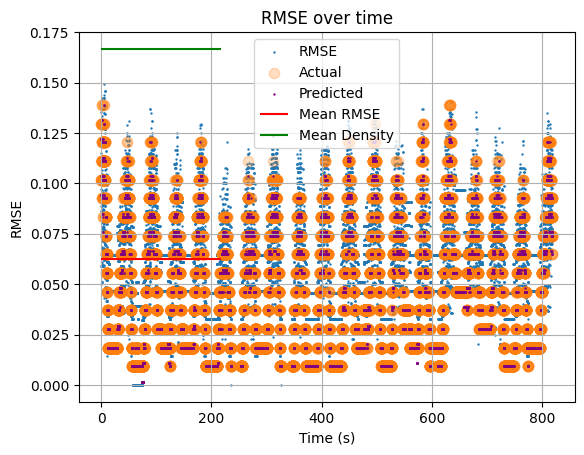

For link with id:  0  the RMSE is:  0.0625711782929875


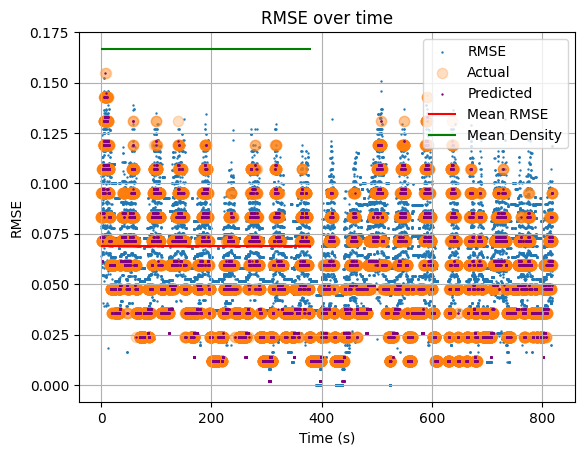

For link with id:  1  the RMSE is:  0.06869256343556793


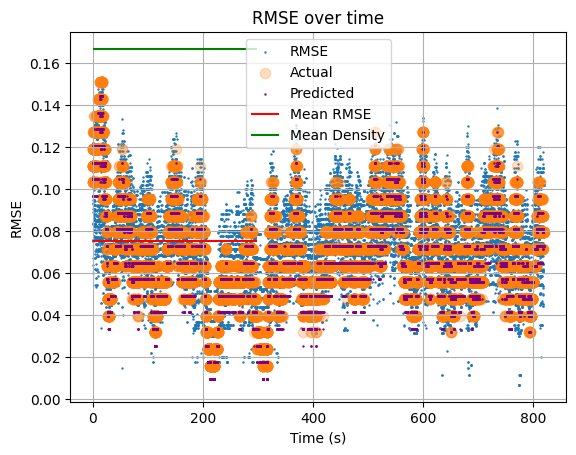

For link with id:  2  the RMSE is:  0.07499449258431179


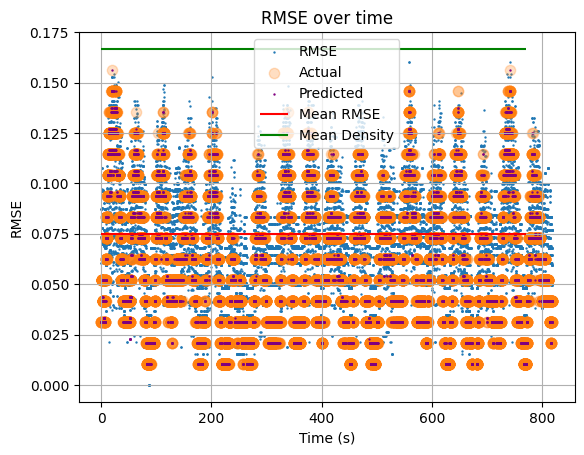

For link with id:  3  the RMSE is:  0.07479554913112593


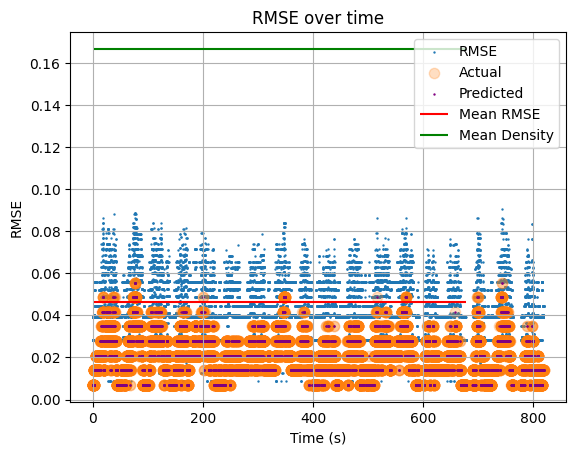

For link with id:  4  the RMSE is:  0.04651940154167174


In [20]:
for segment_id in vehicle_count["link_id"].unique():
    times = times_dict[segment_id]
    rmses = rmses_dict[segment_id]
    predict_mean = predict_mean_dict[segment_id]
    actual_mean = actual_mean_dict[segment_id]
    
    plt.scatter(times[:], rmses[:], label="RMSE", s=0.5)
    plt.scatter(times[:], actual_mean[:], label="Actual", s=55, alpha=0.25)
    plt.scatter(times[:], predict_mean[:], label="Predicted", s=0.5, color="purple", alpha=1)
    plt.xlabel("Time (s)")
    plt.ylabel("RMSE")
    plt.title("RMSE over time")
    plt.hlines(np.mean(rmses), times[0], times[-1], label="Mean RMSE", color="red")
    plt.hlines(vehicle_count[vehicle_count["link_id"] == segment_id].density.mean(), times[0], times[-1], label="Mean Density", color="green")
    plt.grid()
    plt.legend()
    plt.show()
    print("For link with id: ", segment_id, " the RMSE is: ", np.mean(rmses))